In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('..')
import random, math
import pyzx as zx
from fractions import Fraction
from pyzx.phasepoly import circuit_phase_polynomial_blocks, optimize_block
%config InlineBackend.figure_format = 'svg'
zx.quantomatic.quantomatic_location = r'C:\Users\John\Desktop\scala.jar'

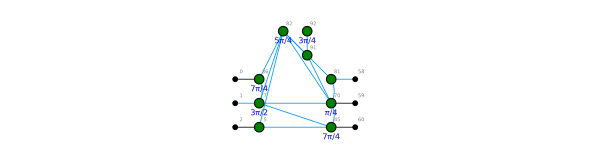

In [19]:
#g = zx.generate.identity(1,2)
#g = zx.quantomatic.edit_graph(g)
g = zx.generate.cliffordT(3,40, p_t=0.2)
zx.simplify.full_reduce(g,quiet=True)
g.normalise()
zx.draw(g,labels=True)

In [12]:
g2 = g.copy()
zx.simplify.to_rg(g2)
zx.quantomatic.edit_graph(g2)

Opening Quantomatic...
Done


Graph(19 vertices, 25 edges)

In [3]:
def generate_parities(targets):
    parities = set()
    for i in range(4):
        a = targets[i]
        parities.add(frozenset([a]))
        for j in range(i+1,4):
            b = targets[j]
            parities.add(frozenset([a,b]))
            for k in range(j+1,4):
                c = targets[k]
                parities.add(frozenset([a,b,c]))
                for l in range(k+1,4):
                    d = targets[l]
                    parities.add(frozenset([a,b,c,d]))
    return parities

s1 = generate_parities([1,2,3,4])
s2 = generate_parities([2,3,4,5])
s3 = generate_parities([1,2,3,6])
s4 = generate_parities([1,2,3,5])
#s5 = generate_parities([1,2,3,5])
len(s1.symmetric_difference(s2).symmetric_difference(s3).symmetric_difference(s4))#.symmetric_difference(s5)

24

alpha = 1/4   beta = 1/4


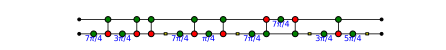

alpha = 1/4   beta = 3/4


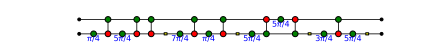

alpha = 1/4   beta = 5/4


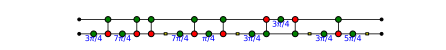

alpha = 1/4   beta = 7/4


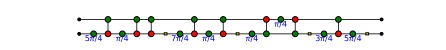

alpha = 3/4   beta = 1/4


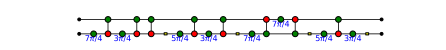

alpha = 3/4   beta = 3/4


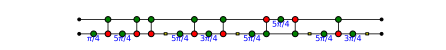

alpha = 3/4   beta = 5/4


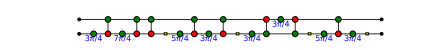

alpha = 3/4   beta = 7/4


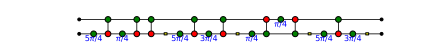

alpha = 5/4   beta = 1/4


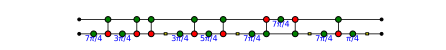

alpha = 5/4   beta = 3/4


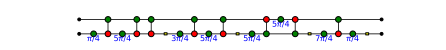

alpha = 5/4   beta = 5/4


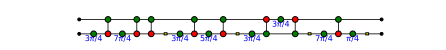

alpha = 5/4   beta = 7/4


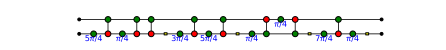

alpha = 7/4   beta = 1/4


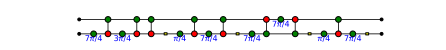

alpha = 7/4   beta = 3/4


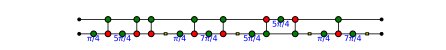

alpha = 7/4   beta = 5/4


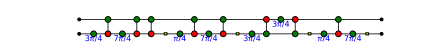

alpha = 7/4   beta = 7/4


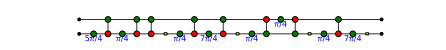

In [29]:
def generate_identity(alpha, beta):
    cb = zx.Circuit(2)
    cb.add_gate("NOT",0)
    cb.add_gate("ZPhase",0,beta)
    cb.add_gate("ZPhase",1,beta)
    cb.add_gate("ParityPhase", -beta, 0, 1)
    cb.add_gate("NOT",0)

    ca = zx.Circuit(2)
    ca.add_gate("ZPhase", 1, Fraction(3,2))
    ca.add_gate("XPhase", 1, Fraction(3,2))
    ca.add_gate("ZPhase",0,alpha)
    ca.add_gate("ZPhase",1,alpha)
    ca.add_gate("ParityPhase", -alpha, 0, 1)
    ca.add_gate("XPhase", 1, Fraction(1,2))
    ca.add_gate("ZPhase", 1, Fraction(1,2))

    c = cb.copy()
    c.add_circuit(ca)
    c.add_circuit(cb.adjoint())
    c.add_circuit(ca.adjoint())
    return c

for i in range(1,8,2):
    alpha = Fraction(i,4)
    for j in range(1,8,2):
        beta = Fraction(j,4)
        c = generate_identity(alpha, beta)
        g = c.to_graph()
        zx.simplify.full_reduce(g)
        g2 = g.copy()
        c2 = zx.extract.streaming_extract(g2)
        c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
        #c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
        g = c3.to_graph()
        zx.simplify.id_simp(g,quiet=True)
        print("alpha =",alpha, "  beta =", beta)
        display(zx.draw(g,h_edge_draw='box',figsize=(6,0.5)))
        #zx.simplify.gadgetize(g)
        #edges = [(49,55),(55,49),(59,65),(65,59)]
        #zx.simplify.pivot_simp(g,matchf=lambda e: e in edges, quiet=True)
        #print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
        

#zx.draw(c)

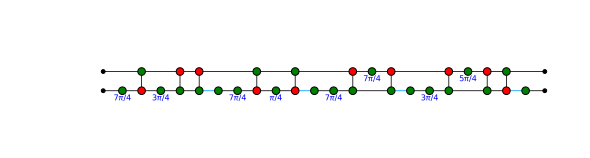

In [39]:
g = zx.generate.circuit_identity_commuting_controls(Fraction(1,4),Fraction(1,4))
zx.simplify.full_reduce(g)
c = zx.extract.streaming_extract(g).to_basic_gates()
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
c3, blocks = circuit_phase_polynomial_blocks(c2,optimize=True)
zx.draw(c3)

[]


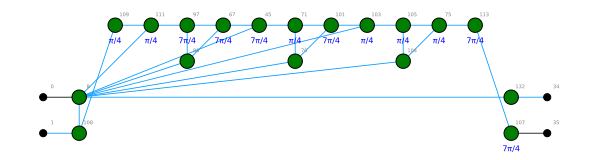

In [39]:
#c = generate_identity(Fraction(5,4),Fraction(7,4))
g = c.to_graph()
zx.simplify.full_reduce(g)
zx.simplify.full_reduce(g)
# zx.simplify.gadgetize(g)
# edges = [(49,55),(55,49),(59,65),(65,59)]
# zx.simplify.pivot_simp(g,matchf=lambda e: e in edges)
# zx.simplify.id_simp(g)
m = zx.rules.match_gadgets_phasepoly(g)
print(m)
#print(alpha, beta, [g.phase(v).numerator for v in g.vertices() if g.phase(v) != 0 and g.phase(v).denominator!=1])
#zx.gadget_simp(g)
# zx.simplify.id_simp(g)
#zx.full_reduce(g)
g.normalise()
zx.draw(g,labels=True)

In [35]:
zx.compare_tensors(g.to_tensor(), zx.generate.identity(2).to_tensor())

True

In [31]:
zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


Graph(18 vertices, 23 edges)

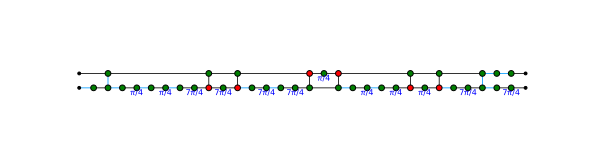

In [36]:
g2 = g.copy()
c2 = zx.extract.streaming_extract(g2)
zx.draw(c2.to_graph())

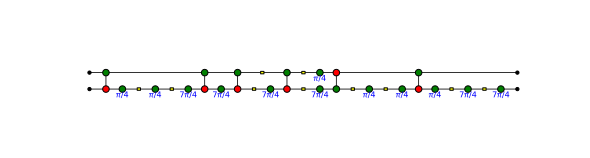

In [37]:
c3, blocks = circuit_phase_polynomial_blocks(c2.to_basic_gates(),optimize=True)
c4, blocks = circuit_phase_polynomial_blocks(c3,optimize=True)
g = c4.to_graph()
zx.simplify.id_simp(g,quiet=True)
zx.draw(g,h_edge_draw='box')

In [42]:
zx.compare_tensors(c4,zx.identity(2))

True

In [156]:
g = zx.generate.identity(1,3)
g = zx.quantomatic.edit_graph(g)

Opening Quantomatic...
Done


In [21]:
a = zx.Circuit(2)
a.add_gate("CZ",0,1)
a.add_gate("CNOT",0,1)
b = zx.Circuit(2)
b.add_gate("S",0)
b.add_gate("S",1)
b.add_gate("CNOT",0,1)
b.add_gate("S",1, adjoint=True)
zx.compare_tensors(a,b)

True

In [177]:
t = g.to_tensor()
t2 = t/t.flatten()[0]
inv = np.linalg.inv(t2)
print(inv/inv.flatten()[0])
print(t2)

[[ 1.+0.j          0.+0.j        ]
 [ 0.+0.j         -0.+2.41421356j]]
[[ 1.+0.j          0.+0.j        ]
 [ 0.+0.j         -0.-0.41421356j]]


In [182]:
import math
1/(math.sqrt(2)-1)

2.4142135623730945

In [11]:
c = zx.Circuit.from_qc_file(r'../circuits/Other/nth_prime6.tfc')
g = c.to_graph()
print(zx.tcount(g))
while True:
    zx.full_reduce(g, quiet=False)
    break
    m = zx.rules.match_gadgets_phasepoly(g)
    if not m: break
    else: 
        print("Found {:d} phasepoly matches".format(len(m)))
        print(" ".join(str((len(b)-8)*2+1) for a,b in m))
        print("T-count before: ", zx.tcount(g))
        zx.rules.apply_gadget_phasepoly(g, m)
        print("T-count after: ", zx.tcount(g))
#zx.full_reduce(g, quiet=False)
g.normalise()
zx.tcount(g)

567
spider_simp: 206. 169. 101. 57. 37. 24. 8. 3. 1.  9 iterations
id_simp: 88. 29.  2 iterations
spider_simp: 26.  1 iterations
pivot_simp: 26. 1.  2 iterations
lcomp_simp: 15. 15. 2. 2.  4 iterations
id_simp: 3.  1 iterations
spider_simp: 2. 1.  2 iterations
pivot_simp: 1.  1 iterations
lcomp_simp: 2. 2.  2 iterations
Boundary Pivot: Unfused 15 nodes for 15 possible pivots
pivot_simp: 2.  1 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
lcomp_simp: 2. 1. 1.  3 iterations
id_simp: 1.  1 iterations
spider_simp: 1.  1 iterations
pivot_simp: 1.  1 iterations
Vertex count:  1877
T-count:  487
Gadgetized 487 nodes
pivot_simp: 169. 102. 49. 39. 29. 15. 8. 8. 5. 5. 3. 7. 7. 2. 3. 2. 2. 2. 2. 1. 3. 1. 1. 1.  24 iterations
Back to clifford_simp
id_simp: 12.  1 iterations
spider_simp: 2. 3. 1. 1. 1. 1. 1. 1. 1.  9 iterations
pivot_simp: 4. 4. 7. 9. 4. 4. 5. 6. 3. 3. 2.  11 iterations
id_simp: 28.  1 iterations
spider_simp: 13. 5. 4. 2. 1. 1. 1.  7 iterations
pivot_simp: 4. 1

279

In [7]:
g2 = g.copy()
g2.normalise()
c = zx.extract.streaming_extract(g2,quiet=True).to_basic_gates()
print(c.stats())

Circuit  on 9 qubits with 5136 gates.
        279 T-like gates
        4857 Cliffords among which 
        2371 2-qubit gates and 2280 Hadamard gates.


In [8]:
c2, blocks = circuit_phase_polynomial_blocks(c,optimize=True)
print(c2.stats())

Circuit  on 9 qubits with 3826 gates.
        279 T-like gates
        3547 Cliffords among which 
        2213 2-qubit gates and 1168 Hadamard gates.


In [8]:
from pyzx.extract import bi_adj
from pyzx.linalg import Mat2

def gflow(g):
    l = dict()
    gflow = dict()
    for v in g.outputs:
        l[v] = 0

    inputs = set(g.inputs)
    processed = set(g.outputs)
    vertices = set(g.vertices())
    k = 1
    while True:
        correct = set()
        #unprocessed = list()
        processed_prime = [v for v in processed.difference(inputs) if any(w not in processed for w in g.neighbours(v))]
        candidates = [v for v in vertices.difference(processed) if any(w in processed_prime for w in g.neighbours(v))]
        #print(processed_prime, candidates)
        
        zerovec = Mat2([[0] for i in range(len(candidates))])
        #print(unprocessed, processed_prime, zerovec)
        m = bi_adj(g, processed_prime, candidates)
        #print(m)
        for u in candidates:
            vu = zerovec.copy()
            vu.data[candidates.index(u)] = [1]
            #print(m)
            x = m.solve(vu)
            if x:
#                 print(u)
#                 print(m)
#                 print(vu, '.')
#                 print(x, '.')
                correct.add(u)
                try:
                    gflow[u] = {processed_prime[i] for i in range(x.rows()) if x.data[i][0]}
                except:
                    print(processed_prime, x)
                l[u] = k

        if not correct:
            if not candidates:
                return l, gflow, k
            return None
        else:
            processed.update(correct)
            k += 1


({0: 1, 1: 1, 2: 2, 3: 2, 4: 2, 5: 1, 6: 0, 7: 0, 8: 3, 9: 0, 10: 3, 11: 3}, {0: {9}, 1: {6}, 2: {0, 1}, 3: {0}, 4: {0, 1, 5}, 5: {7}, 8: {3}, 10: {4}, 11: {2}}, 4)


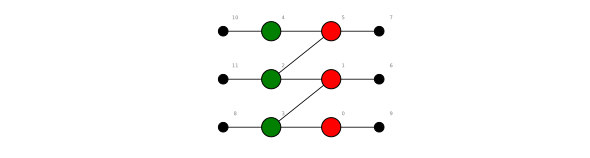

In [45]:
#g = zx.generate.cnots(2,3)
#zx.simplify.spider_simp(g,quiet=True)
print(gflow(g))
zx.draw(g,labels=True)

id_simp: 2.  1 iterations


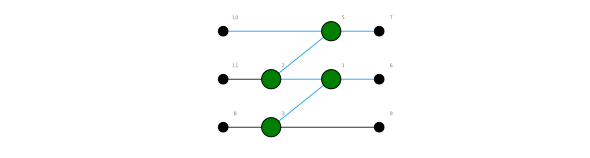

In [48]:
g2 = g.copy()
zx.simplify.clifford_simp(g2)
zx.draw(g2,labels=True)

In [47]:
gflow(g2)

({1: 1, 2: 2, 3: 1, 5: 1, 6: 0, 7: 0, 8: 2, 9: 0, 10: 2, 11: 3},
 {1: {6}, 2: {1}, 3: {9}, 5: {7}, 8: {3}, 10: {1, 5}, 11: {2}},
 4)